# CRAG

CRAG (Corrective Retrieval-Augmented Generation)，就是给传统的 RAG 加上一个“质检员”和“应急预案”。

CRAG 在检索之后，生成之前，强行插入一个“评估纠错”的环节。

它的核心流程分三步：

## 第一步：检索

和普通 RAG 一样，先去向量数据库里找文档。

## 第二步：评估 (EVAL / Grade)

它会启动一个轻量级的 LLM，对着找到的文档和用户的问题看一眼，并打分：

* 准确：认为文档完全能回答问题 → 放行
* 模糊：认为文档沾边，但不太对 → 通过知识提纯，修建一下再用
* 错误：认为文档完全不能回答问题 →扔进垃圾桶

## 第三步：纠正动作

如果发现文档是“错误”的，传统的 RAG 就死机或乱编了，但 CRAG 会启动应急预案：

* **Web Search (网络搜索)**
* **问题重写**

## CRAG 于 Langgraph 的适配性

CRAG 本质上就是一个带有**条件分支**的图：

1. **Node 1**：`Retrieve`
2. **Node 2**：`Grade_Documents`
3. **Conditional Edge**：
   * If `yes` → `Generate`
   * If `no` → `Web_Search`
4. **Node 3**：`Generate`




In [ ]:
from dotenv import load_dotenv
load_dotenv()

True

# Creating VectorDatabase

In [ ]:
from langchain_classic.schema import Document
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import os

embeddings = GoogleGenerativeAIEmbeddings(
    model="models/text-embedding-004",
    google_api_key=os.getenv("GOOGLE_API_KEY")
)

docs = [
    Document(
        page_content="Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.",
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content="Bella Vista offers a range of dishes with prices that cater to various budgets. Appetizers start at $8, main courses range from $15 to $35, and desserts are priced between $6 and $12.",
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content="Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.",
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content="Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, and the brunch menu includes both classic breakfast items and Italian specialties.",
        metadata={"source": "restaurant_info.txt"},
    ),
]

# `Chroma`

`Chroma` 是一个开源的向量数据库，专门用于存储和检索文本嵌入向量。

## 核心功能

* 存储向量：把文档转成向量后持久化存储
* 相似度搜索：根据用户问题找到最相关的文档片段
* 轻量级：可以直接嵌入应用，无需额外服务
* 持久化：支持保存到磁盘，重启后数据不丢失

In [ ]:
# # 体验下

# # 测试 retriever 返回内容
# question = "who is the owner of Bella Vista?"
# docs = retriever.invoke(question)

# for i, doc in enumerate(docs):
#     print(f"--- Document {i+1} ---")
#     print(f"Content: {doc.page_content[:100]}...")  # 只显示前100字符
#     print(f"Metadata: {doc.metadata}")
#     print()

In [ ]:
from langchain_community.vectorstores import Chroma

# 建立向量数据库：1）将文档列表转换为向量；2）把这些向量存入 Chroma 数据库。此时，`db`就是一个完整的向量数据库实例
db = Chroma.from_documents(
    docs,
    embeddings,
    persist_directory="./data/chroma_db",
)

# db_as_retriever() 建立检索入口：把数据库包装成 Langchain 标准的 Retriever 接口，方便在 Chain 或 Graph 中使用。
# retriever = db.as_retriever()

retriever = db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={
        "k": 3,                    # 最多返回 3 个
        "score_threshold": 0.5    # 相似度 > 0.7 才返回
    }
)


In [ ]:
from typing import TypedDict, Literal

class AgentState(TypedDict):
    question: str
    grades: list[str]
    llm_output: str
    documents: list[str]
    on_topic: Literal["Yes", "No"]

## `retriever.invoke()`

内部黑盒 (Under the Hood)
当你调用 .invoke() 时，底下通常发生了这一连串物理动作（以 Vector Store 为例）：

Embedding (向量化): 把你的文字问题扔给 Embedding 模型（如 text-embedding-004），转化成一串数字向量（比如 [0.1, -0.5, 0.8...]）。

Similarity Search (相似度搜索): 拿着这串数字，去向量数据库（Vector DB）里做数学题（通常是计算余弦相似度），找出数据库里和这串数字“距离最近”的 Top K 个片段。

Fetch (抓取): 把这 K 个片段捞出来，打包成 Document 对象返回。

In [ ]:
def retrieve_docs(state: AgentState):
    question = state["question"]
    documents = retriever.invoke(question) # 每个 Document 包含文档文本内容和元数据
    state["documents"] = [doc.page_content for doc in documents]
    return state

In [ ]:
llm = ChatOpenAI(
    model="deepseek-chat",
    base_url="https://api.deepseek.com",
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    temperature=0
)

In [ ]:
from langchain_experimental.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

class GradeQuestion(BaseModel):
    """Y/N value to check whether a question is related to the restaurant Bella Vista"""
    score: str = Field(description="Question is about restaurant? If yes → 'Yes' if not → 'No'")

def question_classifier(state: AgentState):
    question = state["question"]
    system = """You are a grader assessing the relevance of a retrieved document to a user question. \n
    Only answer if the question is about one of the following topics:
    1. Information about the owner of Bella Vista (Antonio Rossi).
    2. Prices of dishes at Bella Vista.
    3. Opening hours of Bella Vista.
    4. Available menus at Bella Vista.

    If the question IS about these topics response with "Yes", otherwise respond with "No"."""

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}")
        ]
    )

    structured_llm = llm.with_structured_output(GradeQuestion)
    grade_llm = grade_prompt | structured_llm
    result = grade_llm.invoke({"question": question})
    state["on_topic"] = result.score
    return state

In [ ]:
def on_topic_router(state: AgentState):
    on_topic = state["on_topic"]
    if on_topic.lower() == 'yes':
        return "on_topic"
    return "off_topic"

In [ ]:
def off_topic_response(state: AgentState):
    state["llm_output"] = "I can't respond to that!"
    return state

In [ ]:
class GradeDocuments(BaseModel):
    """Y/N value to check whether documents are relevant to the question"""
    score: str = Field(description="Documents are relevant? If yes → 'Yes' if not → 'No'")

def document_grader(state: AgentState):
    docs = state["documents"]
    question = state["question"]
    system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'Yes' or 'No' score to indicate whether the document is relevant to the question."""

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Retrieved document: \n\n {document} \n\n User Question: {question}")
        ]
    )

    structured_llm = llm.with_structured_output(GradeDocuments)
    grade_llm = grade_prompt | structured_llm
    scores = []
    for doc in docs:
        result = grade_llm.invoke({"document": doc, "question": question})
        scores.append(result.score)
    state["grades"] = scores
    return state

In [ ]:
def gen_router(state: AgentState):
    grades = state["grades"]
    print("DOCUMENT GRADES:", grades)

    if any(grade.lower() == 'yes' for grade in grades):
        filtered_grades = [grade for grade in grades if grade.lower() == 'yes']
        print("FILTERED DOCUMENT GRADES:", filtered_grades)
        return "generate"
    return "rewrite_query"

In [ ]:
from langchain_core.output_parsers import StrOutputParser

def rewrite(state: AgentState):
    question = state["question"]
    system = """You a question re-writer that converts an input question to a better version that is optimized \n
    for retrieval. Look at the input and try to reason about the underlying semantic intent / meaning"""

    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )
    question_rewriter = re_write_prompt | llm | StrOutputParser()
    output = question_rewriter.invoke({"question": question})
    state["question"] = output
    return state

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


def generate_answer(state: AgentState):
    question = state["question"]
    context = state["documents"]

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """

    prompt = ChatPromptTemplate.from_template(
        template=template,
    )
    chain = prompt | llm | StrOutputParser()
    result = chain.invoke({"question": question, "context": context})
    state["llm_output"] = result
    return state

In [ ]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("rewrite_query", rewrite)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("document_grader", document_grader)

workflow.add_edge("off_topic_response", END)
workflow.add_edge("retrieve_docs", "document_grader")
workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrieve_docs",
        "off_topic": "off_topic_response",
    },
)
workflow.add_conditional_edges(
    "document_grader",
    gen_router,
    {
        "generate": "generate_answer",
        "rewrite_query": "rewrite_query",
    },
)
workflow.add_edge("rewrite_query", "retrieve_docs")
workflow.add_edge("generate_answer", END)


workflow.set_entry_point("topic_decision")

app = workflow.compile()

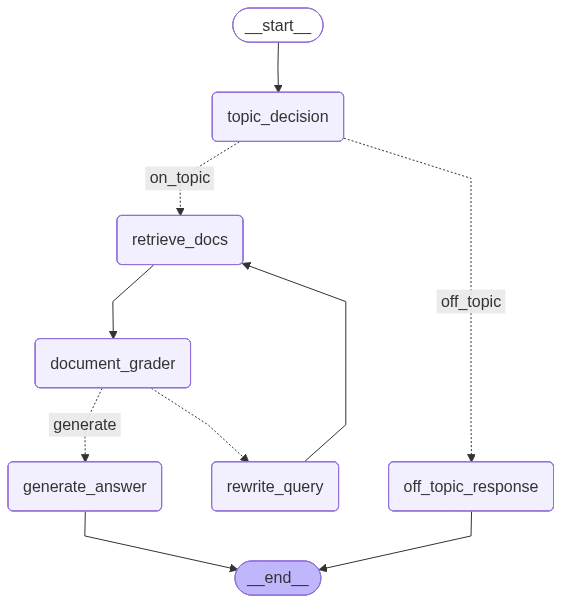

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(e)

In [ ]:
result = app.invoke({"question": "How is the weather?"})
result["llm_output"]

"I can't respond to that!"

In [ ]:
result = app.invoke({"question": "who is the owner of the Bella vista??"})
result["llm_output"]

DOCUMENT GRADES: ['Yes', 'Yes', 'Yes']
FILTERED DOCUMENT GRADES: ['Yes', 'Yes', 'Yes']


'Based on the context provided, the owner of Bella Vista is Antonio Rossi.'

: 